In [1]:
# https://towardsdatascience.com/forecasting-atmospheric-co2-concentration-with-python-c4a99e4cf142
# https://gml.noaa.gov/ccgg/trends/data.html
# https://medium.com/unit8-machine-learning-publication/darts-time-series-made-easy-in-python-5ac2947a8878

!pip install darts
!pip install dask[dataframe]

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 7.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.6/556.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
zsh:1: no matches found: dask[dataframe]


/opt/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
from google.colab import files

files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
df = pd.read_csv('https://github.com/palasatenea66/DATASETS/raw/main/monthly_in_situ_co2_mlo2022.csv',
                  comment = '"', header = [0,1,2], na_values = '-99.99')

df.columns

MultiIndex([(        '  Yr',            '    ',         '    '),
            (         ' Mn',             '   ',          '   '),
            (    '    Date',        '        ',     '   Excel'),
            (  '      Date',      '          ',   '          '),
            (    '     CO2',        '        ',     '   [ppm]'),
            (  'seasonally',      '  adjusted',   '    [ppm] '),
            ( '        fit',     '           ',  '      [ppm]'),
            ('  seasonally',    'adjusted fit',    '    [ppm]'),
            (   '      CO2',       '   filled', '       [ppm]'),
            ( ' seasonally', 'adjusted filled',    '    [ppm]')],
           )

In [ ]:
df.columns.values

array([('  Yr', '    ', '    '), (' Mn', '   ', '   '),
       ('    Date', '        ', '   Excel'),
       ('      Date', '          ', '          '),
       ('     CO2', '        ', '   [ppm]'),
       ('seasonally', '  adjusted', '    [ppm] '),
       ('        fit', '           ', '      [ppm]'),
       ('  seasonally', 'adjusted fit', '    [ppm]'),
       ('      CO2', '   filled', '       [ppm]'),
       (' seasonally', 'adjusted filled', '    [ppm]')], dtype=object)

In [ ]:
cols = [' '.join(col).replace(' ', '') for col in df.columns.values]  
# recorre cada nombre de columna
# - si es un MultiIndex, lo une con ' '.join()
# - luego borra espacios con .replace(' ', '')
# genera una lista de nombres de columnas limpios

df = df.set_axis(cols, axis=1)  
# asigna la nueva lista de nombres como encabezados del DataFrame

print(df.columns)  
# imprime los nombres de las columnas resultantes


Index(['Yr', 'Mn', 'DateExcel', 'Date', 'CO2[ppm]', 'seasonallyadjusted[ppm]',
       'fit[ppm]', 'seasonallyadjustedfit[ppm]', 'CO2filled[ppm]',
       'seasonallyadjustedfilled[ppm]'],
      dtype='object')


In [ ]:
df

,Yr,Mn,DateExcel,Date,CO2[ppm],seasonallyadjusted[ppm],fit[ppm],seasonallyadjustedfit[ppm],CO2filled[ppm],seasonallyadjustedfilled[ppm]
0,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,21259,1958.2027,315.70,314.43,316.20,314.91,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
776,2022,9,44819,2022.7068,NaN,NaN,NaN,NaN,415.95,NaN
777,2022,10,44849,2022.7890,NaN,NaN,NaN,NaN,415.78,NaN
778,2022,11,44880,2022.8740,NaN,NaN,NaN,NaN,417.51,NaN
779,2022,12,44910,2022.9562,NaN,NaN,NaN,NaN,418.95,NaN


In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# Converting Excel date format to datetime
# and setting as dataframe index

df['datetime'] = pd.to_datetime(df['DateExcel'], origin='1899-12-30', unit='D')  # convierte fecha Excel a datetime (origen 30/12/1899, unidad días)
df.set_index('datetime', inplace=True)                                           # usa 'datetime' como índice del DataFrame
df                                                                               # muestra el DataFrame con índice de fechas


,Yr,Mn,DateExcel,Date,CO2[ppm],seasonallyadjusted[ppm],fit[ppm],seasonallyadjustedfit[ppm],CO2filled[ppm],seasonallyadjustedfilled[ppm]
datetime,,,,,,,,,,
1958-01-15,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1958-02-15,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
1958-03-15,1958,3,21259,1958.2027,315.70,314.43,316.20,314.91,315.70,314.43
1958-04-15,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
1958-05-15,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
2022-09-15,2022,9,44819,2022.7068,NaN,NaN,NaN,NaN,415.95,NaN
2022-10-15,2022,10,44849,2022.7890,NaN,NaN,NaN,NaN,415.78,NaN
2022-11-15,2022,11,44880,2022.8740,NaN,NaN,NaN,NaN,417.51,NaN


In [ ]:
# se toma una única columna de la serie de datos, la que contiene los datos sin 'retocar'
df = df[['CO2filled[ppm]']]                  # selecciona solo la columna CO2filled[ppm]

df.rename(columns={'CO2filled[ppm]': 'CO2'}, inplace=True)  # renombra la columna a 'CO2'

df.dropna(inplace=True)                      # elimina filas con valores nulos

df = df.resample('M').sum()                  # cambia frecuencia a mensual y suma valores en cada mes

df                                           # muestra el DataFrame resultante


,CO2
datetime,
1958-03-31,315.70
1958-04-30,317.45
1958-05-31,317.51
1958-06-30,317.25
1958-07-31,315.86
...,...
2022-09-30,415.95
2022-10-31,415.78
2022-11-30,417.51


In [ ]:
type(df)

pandas.core.frame.DataFrame

# Time Series Analysis

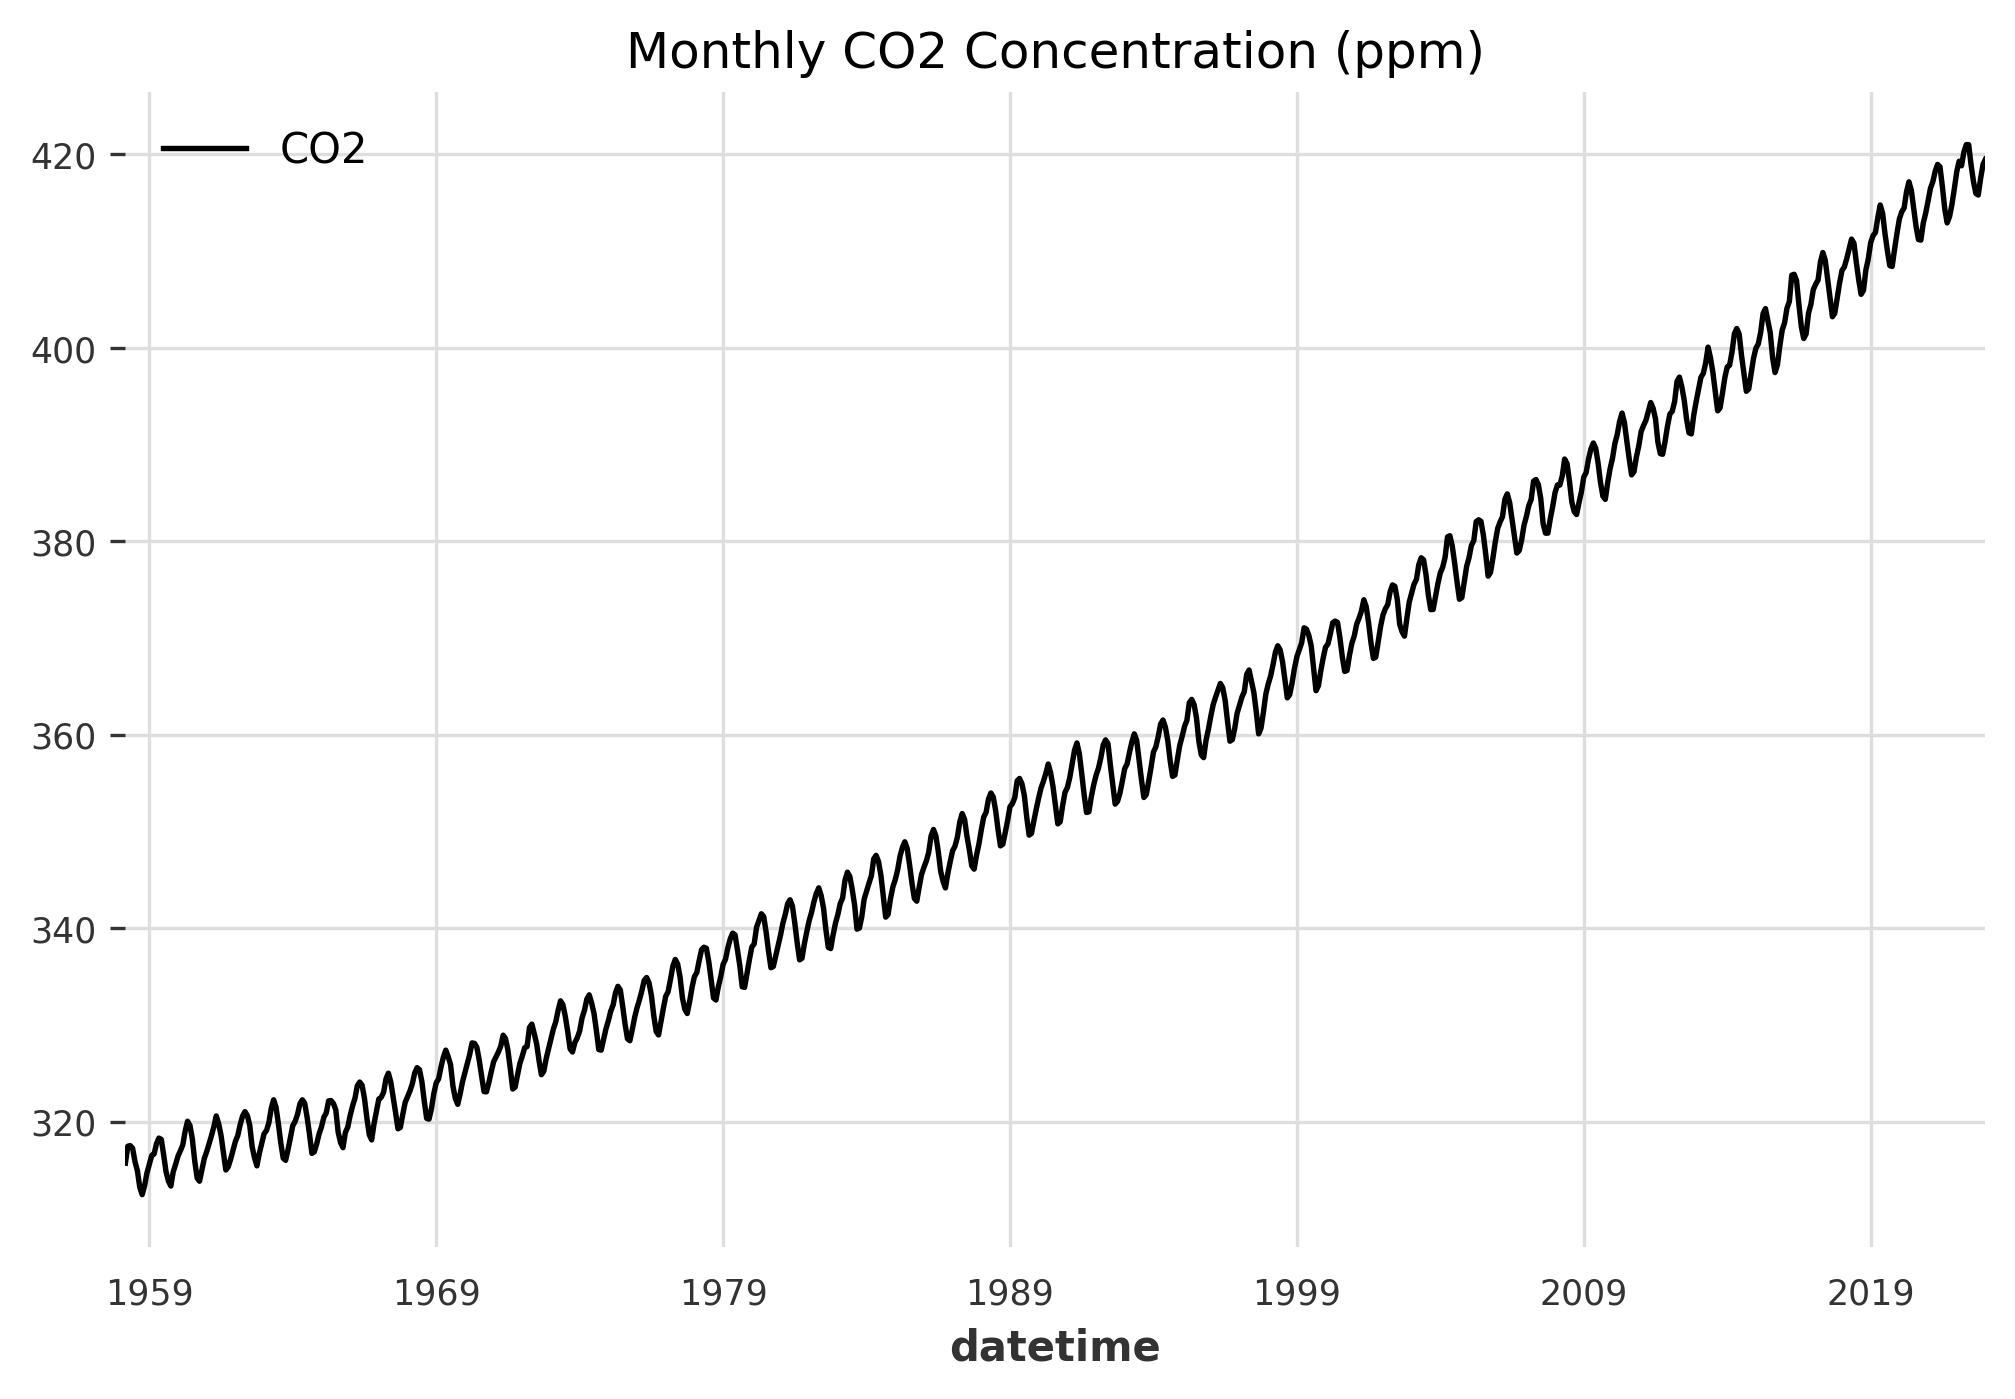

In [ ]:
df.plot(figsize=(8,5))
plt.title('Monthly CO2 Concentration (ppm)')

plt.show()

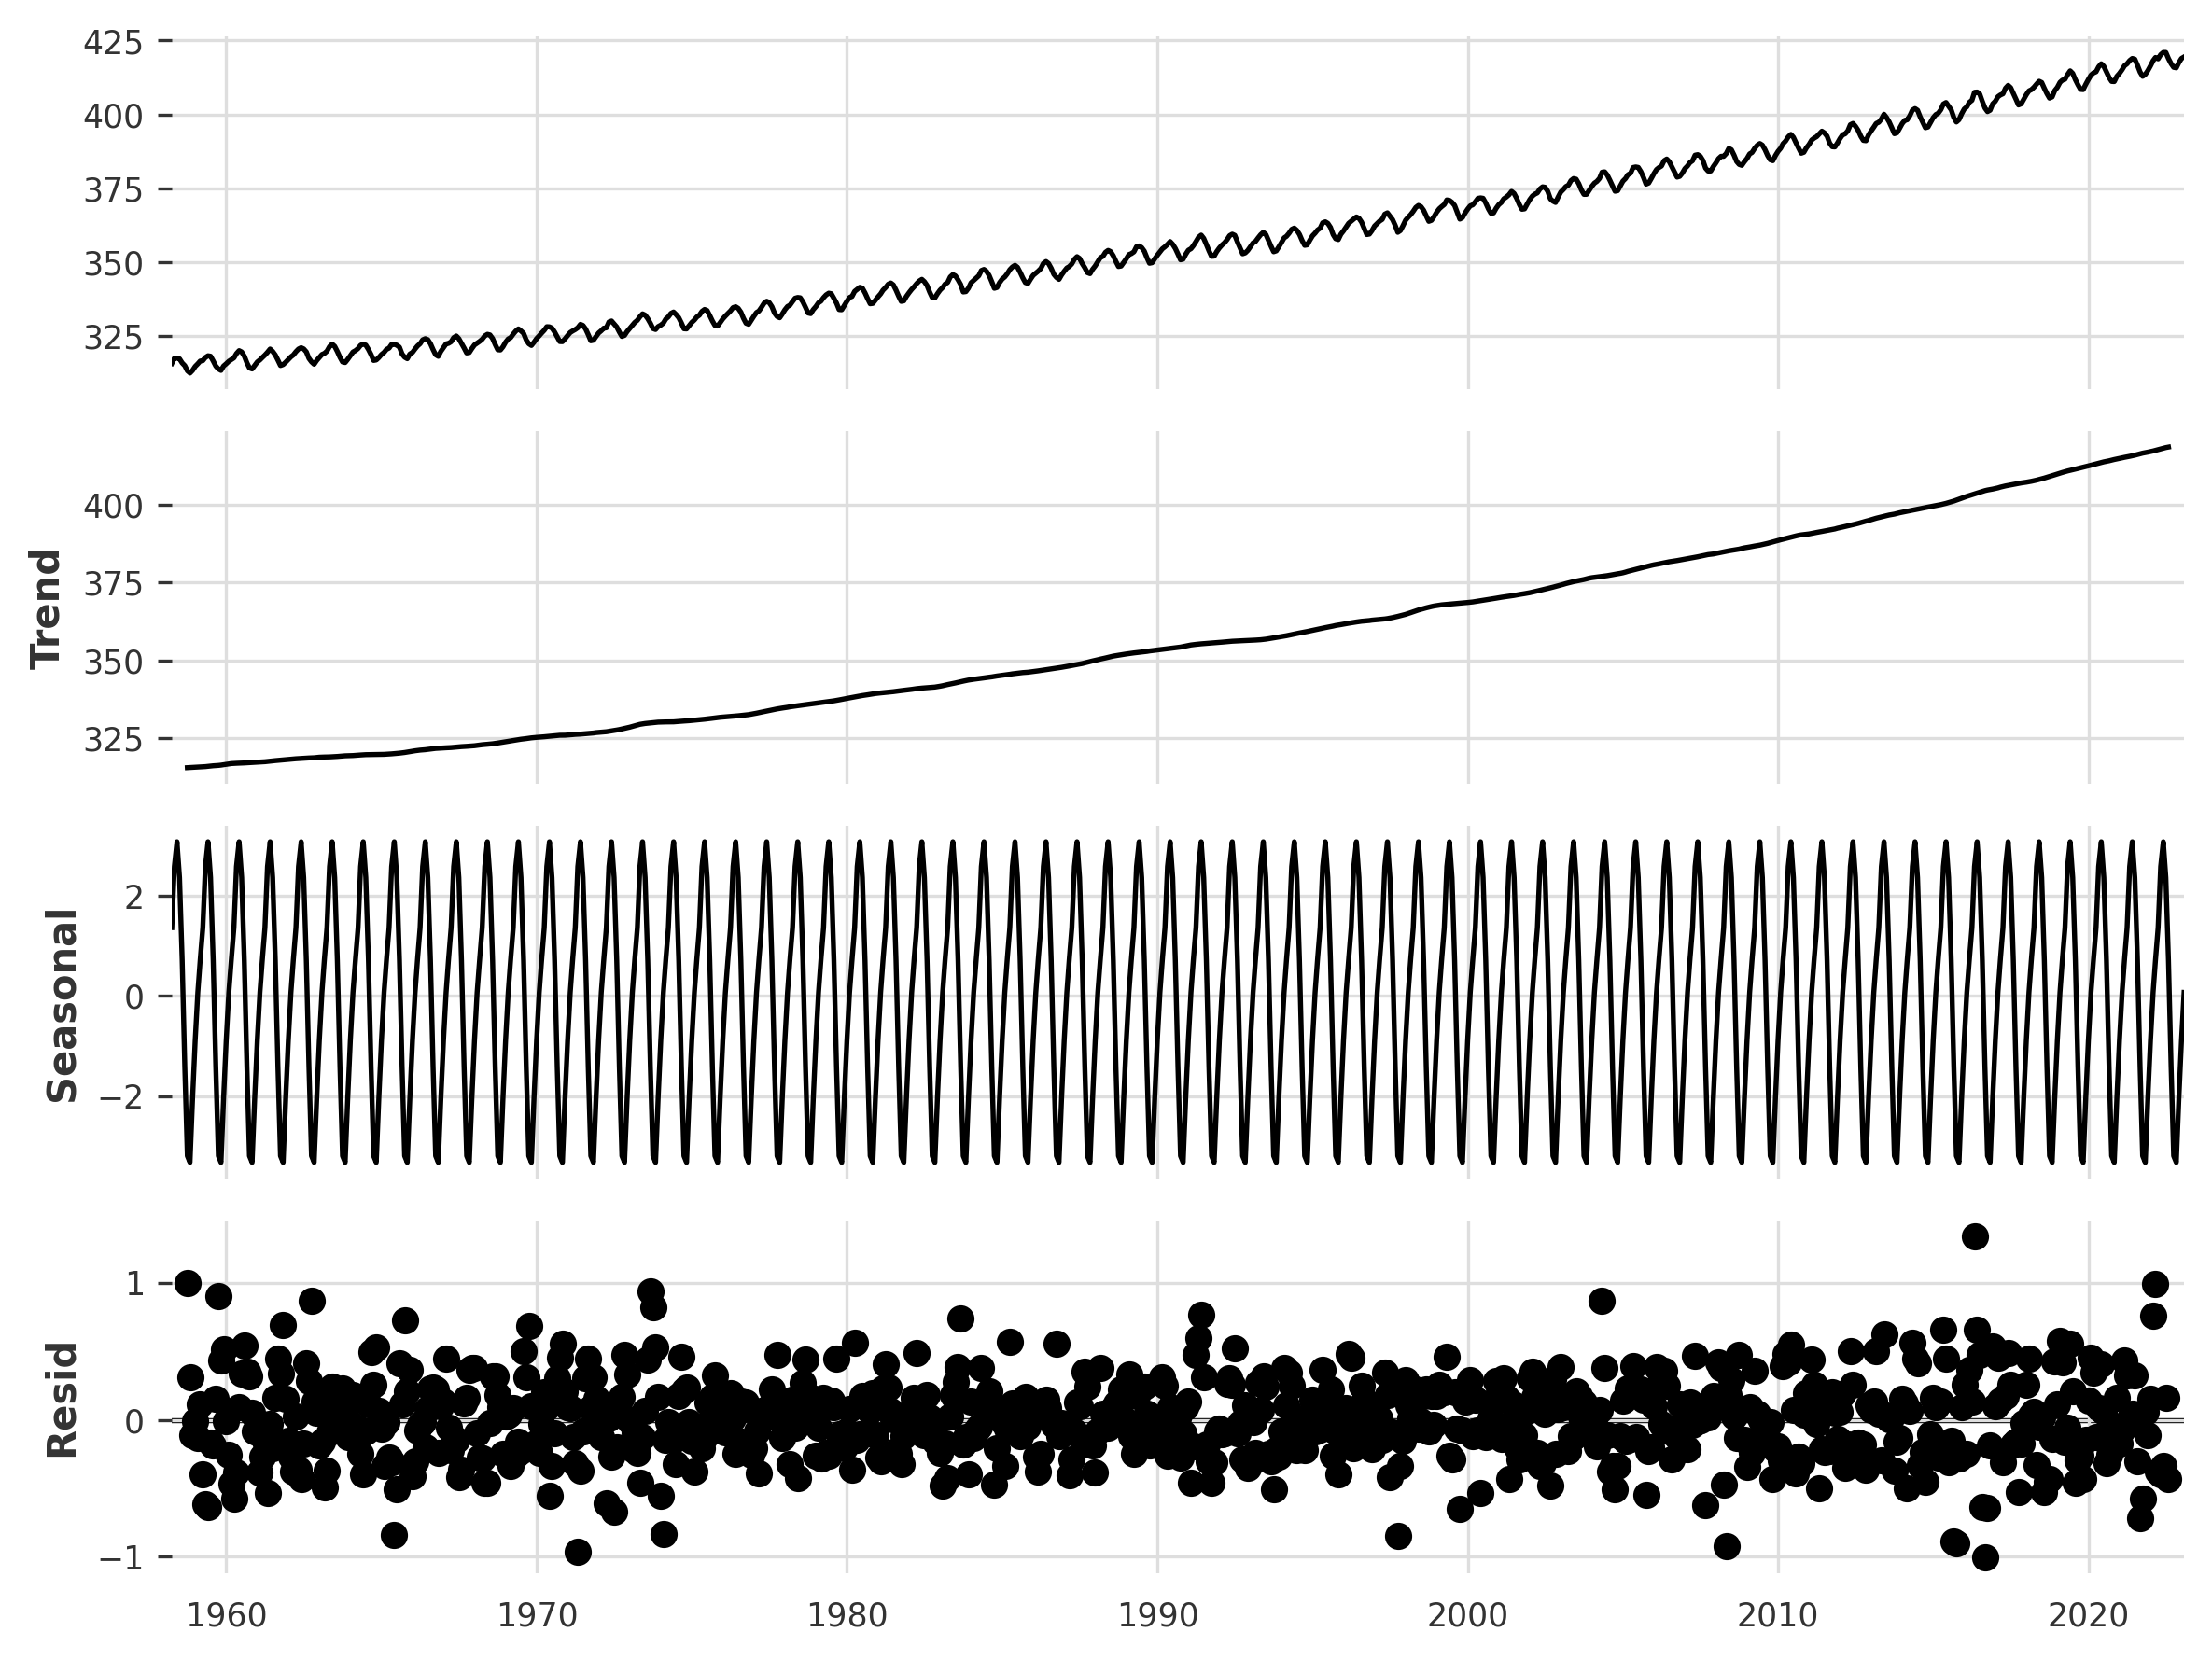

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)  
# Ajusta el tamaño por defecto de todas las figuras en Matplotlib a 8x6 pulgadas.

result = seasonal_decompose(df)  
# Aplica la descomposición estacional a la serie 'df'.
# Divide la serie en:
#   - Trend (tendencia de largo plazo)
#   - Seasonal (componente estacional repetitivo)
#   - Residual (ruido o parte no explicada)
# Por defecto asume modelo 'additive' (serie = tendencia + estacionalidad + residuo).

result.plot()  
# Genera un gráfico con 4 subplots:
#   - Serie original
#   - Tendencia
#   - Estacionalidad
#   - Residuo

plt.show()  
# Muestra la figura en pantalla.


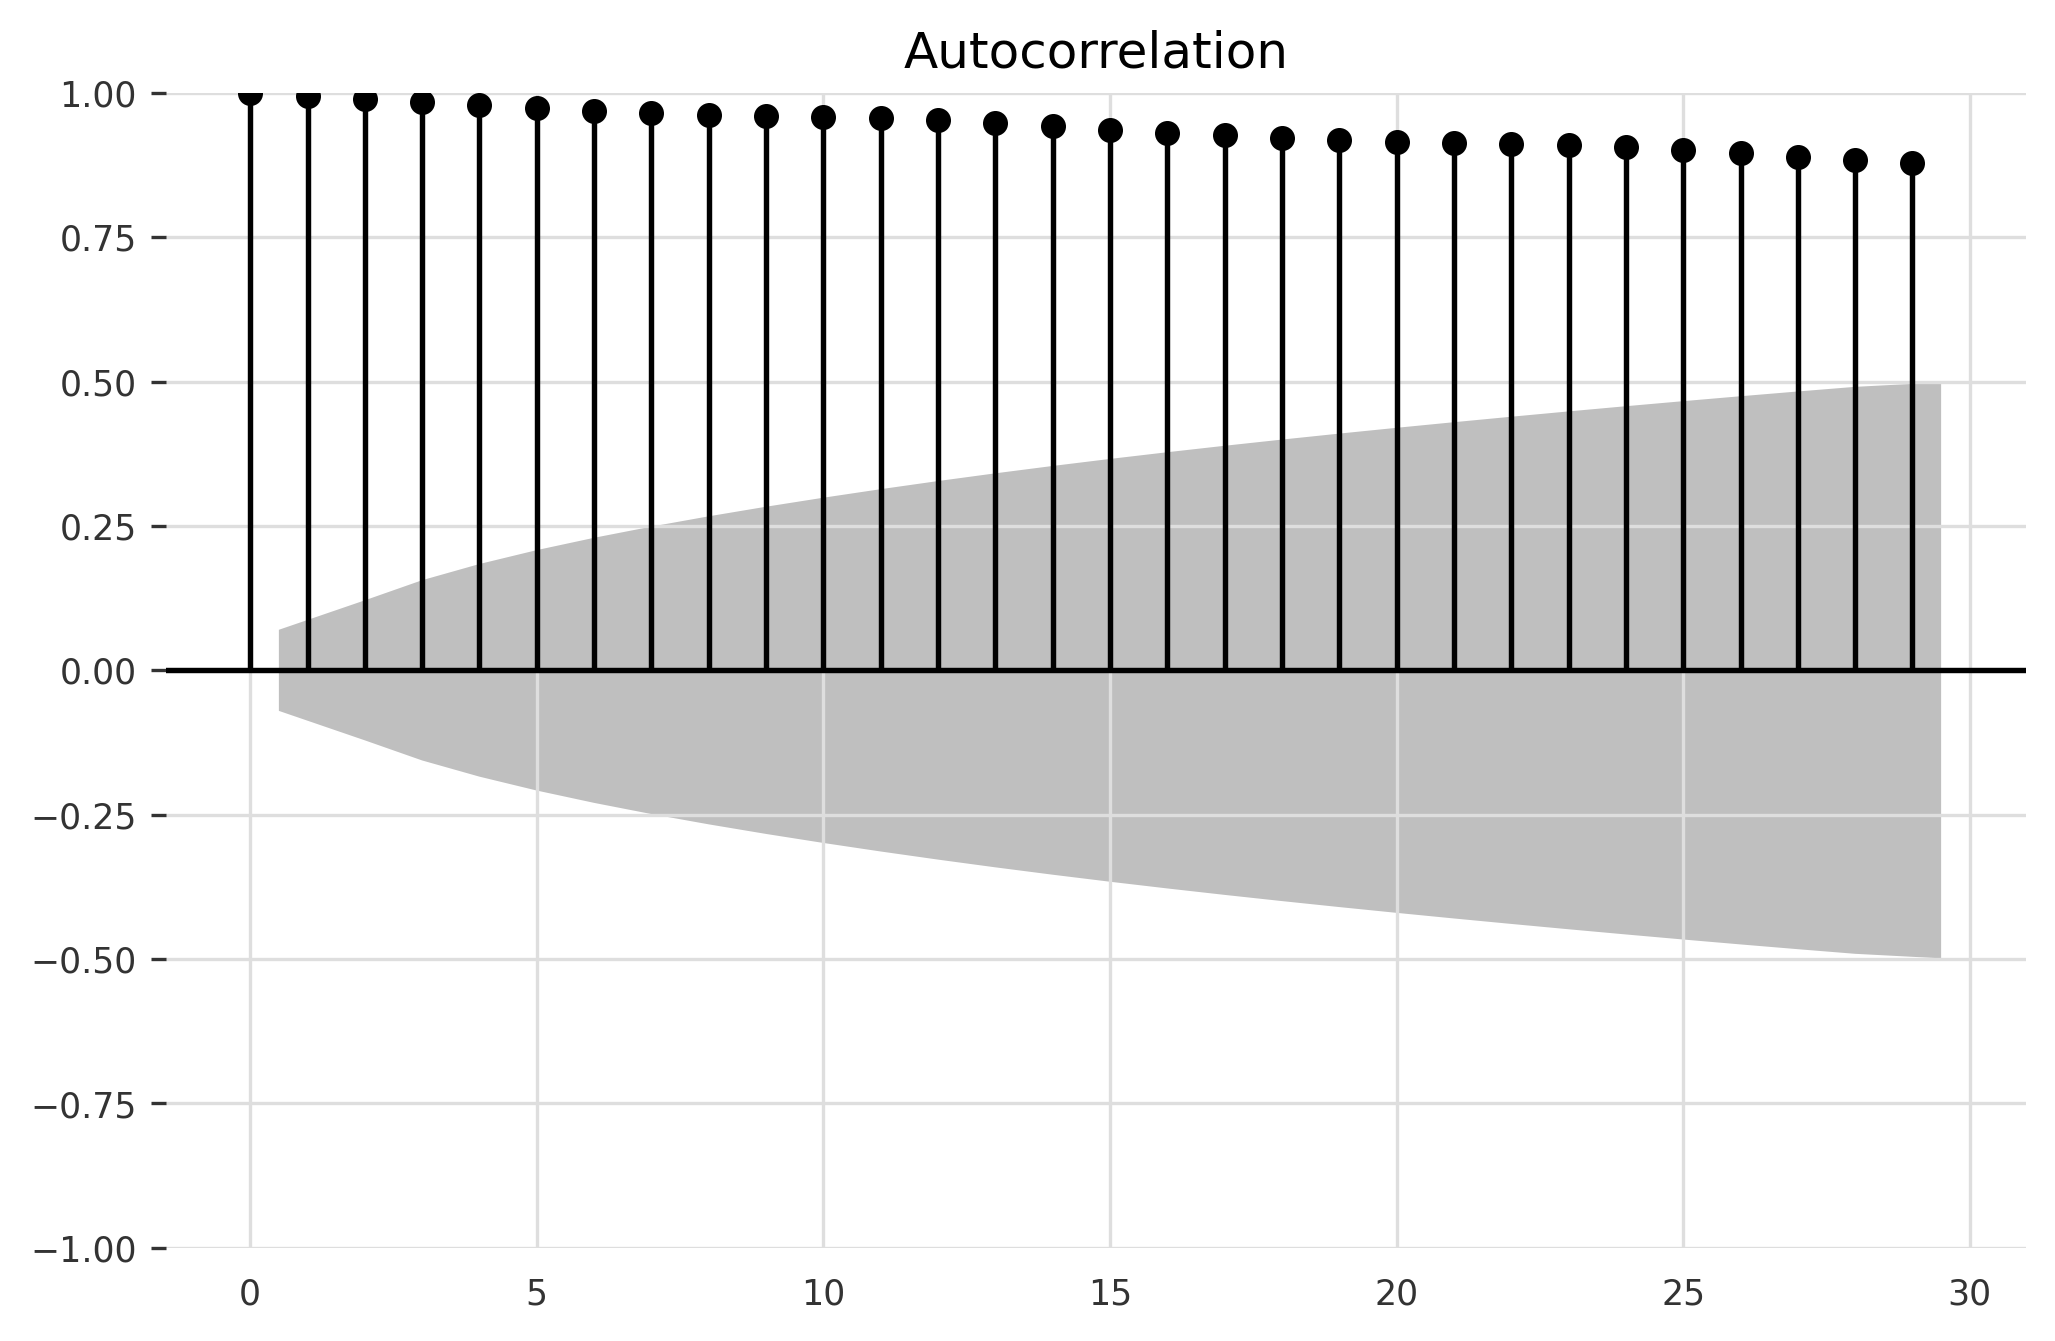

In [ ]:
# https://en.wikipedia.org/wiki/Cross-correlation
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://en.wikipedia.org/wiki/Autocorrelation

fig, ax = plt.subplots(figsize=(8,5))   # crea figura y ejes de 8x5 pulgadas

plot_acf(df, ax=ax)                     # grafica la función de autocorrelación (ACF) de la serie

plt.show()                              # muestra el gráfico en pantalla

In [ ]:
# Loading the pandas dataframe to a TimeSeries object as required by the Darts library
# https://unit8co.github.io/darts/quickstart/00-quickstart.html
# https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_dataframe

series = TimeSeries.from_dataframe(df)

start = pd.Timestamp('123115')     # desde donde hará el pronóstico
df_metrics = pd.DataFrame()   # empty dataframe
series

<TimeSeries (DataArray) (datetime: 779, component: 1, sample: 1)> Size: 6kB
array([[[315.7 ]],

       [[317.45]],

       [[317.51]],

       [[317.25]],

       [[315.86]],

       [[314.93]],

       [[313.21]],

       [[312.44]],

       [[313.33]],

       [[314.67]],

...

       [[420.23]],

       [[420.99]],

       [[420.99]],

       [[418.9 ]],

       [[417.19]],

       [[415.95]],

       [[415.78]],

       [[417.51]],

       [[418.95]],

       [[419.47]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 6kB 1958-03-31 ... 2023-01-31
  * component  (component) object 8B 'CO2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Creating Utility Functions

In [ ]:
# https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383
# https://www.geeksforgeeks.org/how-to-calculate-smape-in-python/
# https://datagy.io/mape-python/

def plot_backtest(series, forecast, model_name):
    idx = -144    # 12*12 → último año si los datos son mensuales
    series[idx:].plot(label='Actual Values')  
    # Grafica los valores reales (últimos 144 puntos).

    forecast[idx:].plot(label='Forecast')  
    # Grafica los valores pronosticados en el mismo rango.

    plt.title(model_name)  
    # Título del gráfico con el nombre del modelo.

    plt.show()  
    # Muestra el gráfico.

def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)  
    # Calcula el MAE (Mean Absolute Error).

    rmse_ = rmse(series, forecast)  
    # Calcula el RMSE (Root Mean Squared Error).

    mape_ = mape(series, forecast)  
    # Calcula el MAPE (Mean Absolute Percentage Error).

    smape_ = smape(series, forecast)  
    # Calcula el SMAPE (Symmetric Mean Absolute Percentage Error).

    r2_score_ = r2_score(series, forecast)  
    # Calcula el R² (qué tan bien el modelo explica la variación de los datos).

    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_,
             'R2': r2_score_}  
    # Guarda los resultados en un diccionario.

    df = pd.DataFrame(dict_, index=[model_name])  
    # Convierte el diccionario en un DataFrame con el nombre del modelo como índice.

    return(df.round(decimals=2))  
    # Devuelve el DataFrame redondeando a 2 decimales.

# Creating a Naive Forecasting Model

100%|██████████| 75/75 [00:00<00:00, 281.91it/s]


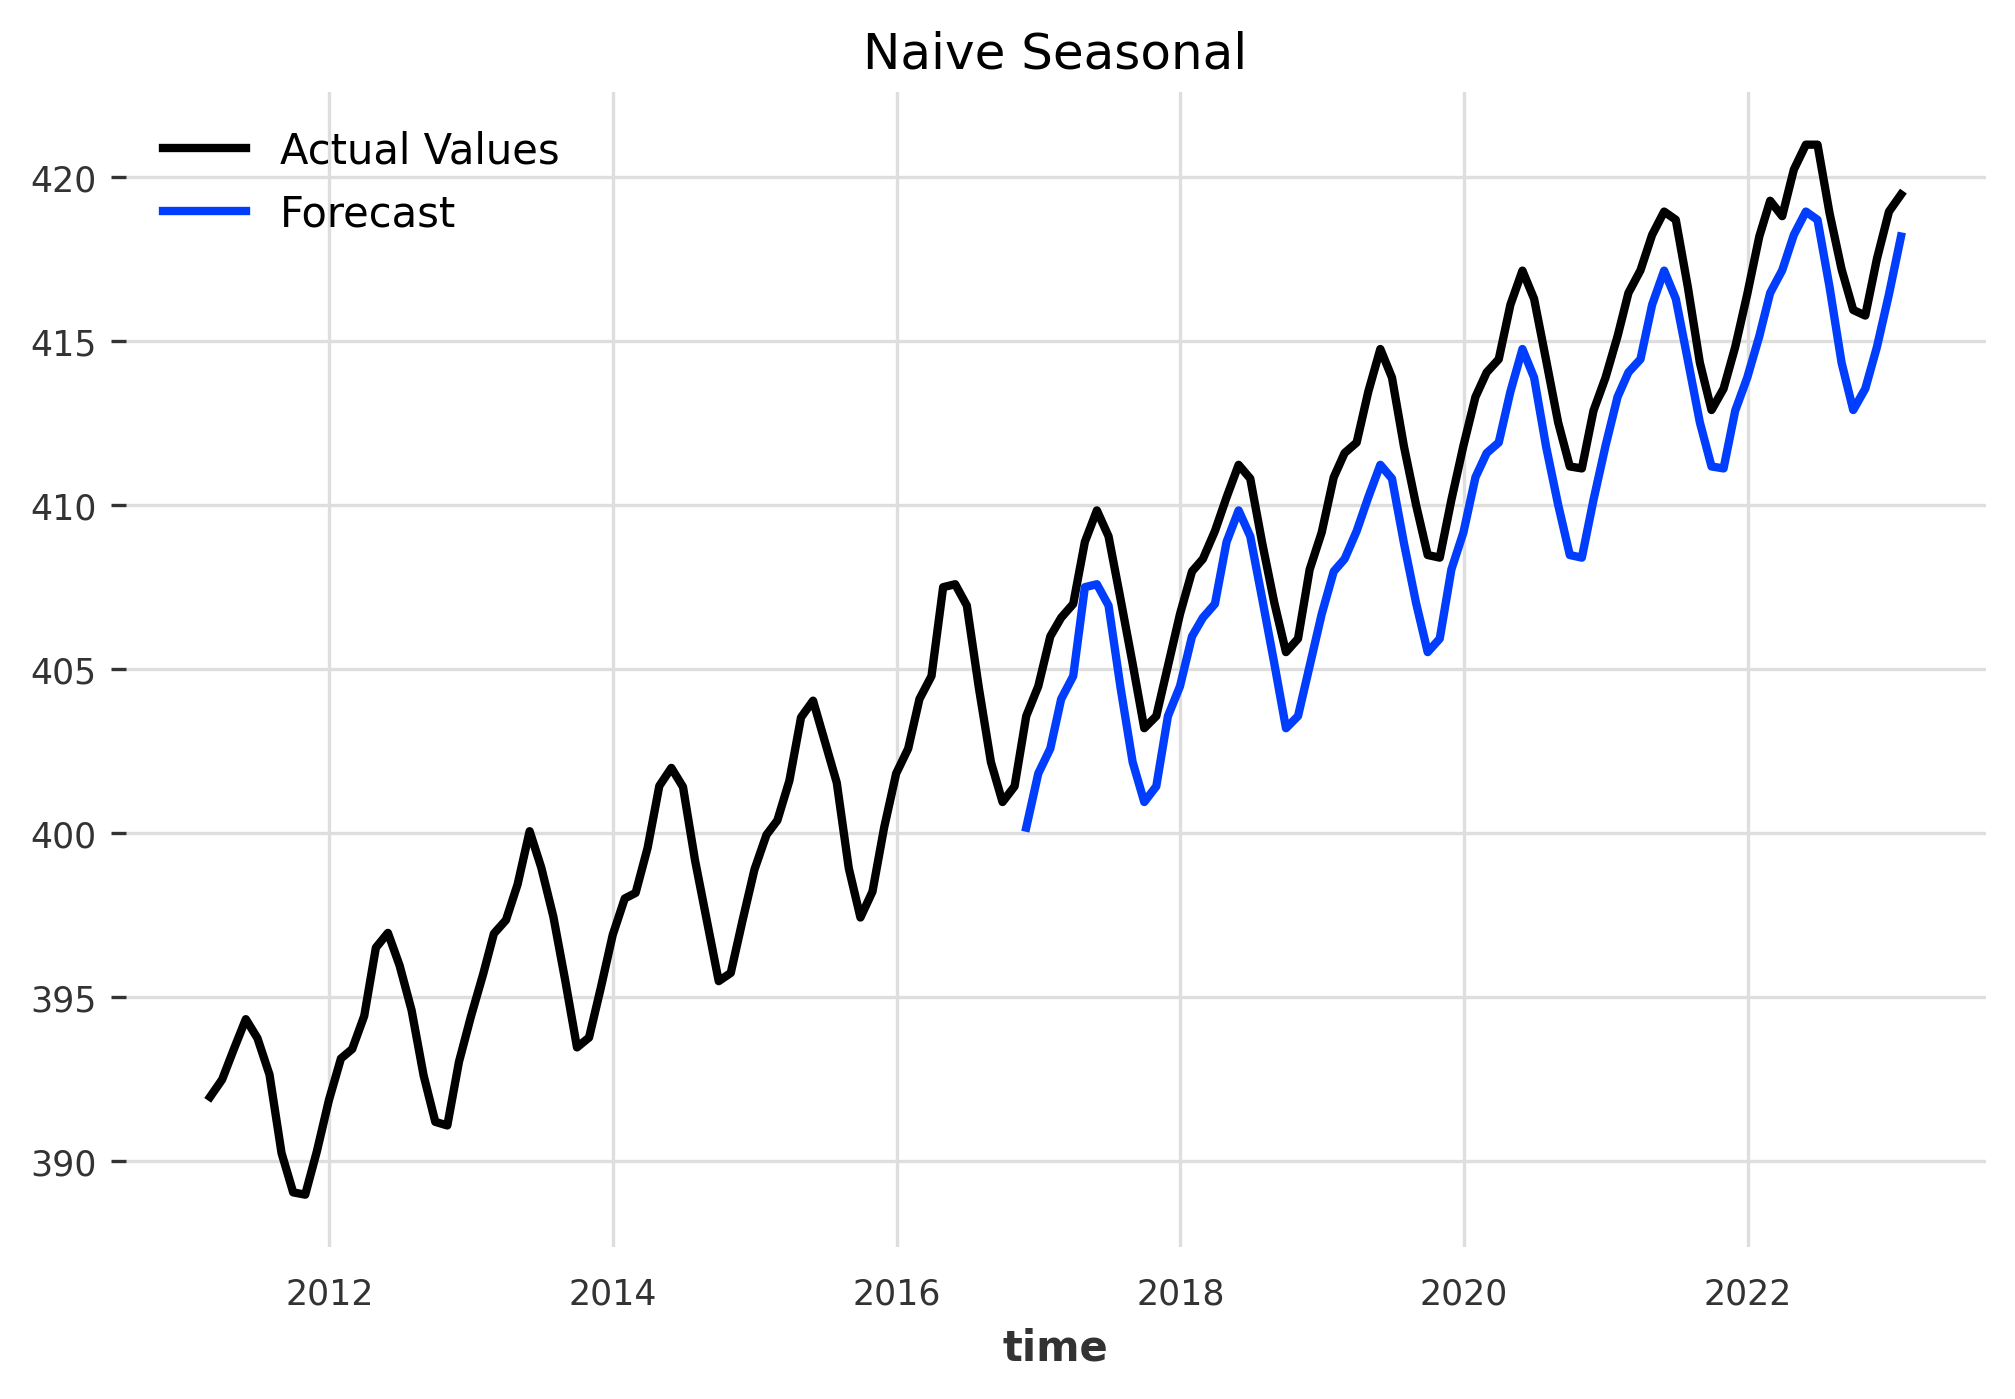

In [ ]:
# Doc oficial de Darts: 
# https://unit8co.github.io/darts/quickstart/00-quickstart.html#Training-forecasting-models-and-making-predictions

model = NaiveSeasonal(K=12)  
# Crea un modelo Naive Seasonal.
# Este modelo asume que los datos se repiten cada "K" pasos.
# K=12 → el pronóstico para cada punto será igual al valor observado 12 pasos antes 
# (ejemplo típico: 12 meses atrás = mismo mes del año anterior).

model_name = 'Naive Seasonal'  
# Guarda el nombre del modelo para usar en los gráficos y métricas.

plt.figure(figsize=(8, 5))  
# Define el tamaño del gráfico.

forecast = model.historical_forecasts(
    series, 
    start=start, 
    forecast_horizon=12, 
    verbose=True
)  
# Genera pronósticos retrospectivos ("backtesting") para evaluar el modelo.
# - series: la serie temporal original.
# - start: punto inicial desde donde comienzan a hacerse los pronósticos.
# - forecast_horizon=12: predice 12 pasos hacia adelante cada vez (ej. 12 meses).
# - verbose=True: muestra en consola el progreso.

plot_backtest(series, forecast, model_name)  
# Usa tu función personalizada para graficar:
#   - Valores reales de la serie.
#   - Valores pronosticados por el modelo Naive Seasonal.


In [ ]:
df_naive = print_metrics(series, forecast, model_name)   # calcula métricas (MAE, RMSE, MAPE, SMAPE, R2) y las guarda en df_naive

df_metrics = pd.concat([df_metrics, df_naive])           # concatena las métricas nuevas con las ya acumuladas en df_metrics

df_naive                                                # muestra en pantalla solo las métricas recién calculadas

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.39,2.45,0.58,0.58,0.73


In [ ]:
df_metrics

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.39,2.45,0.58,0.58,0.73


# Creating an Exponential Smoothing Forecasting Model

100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


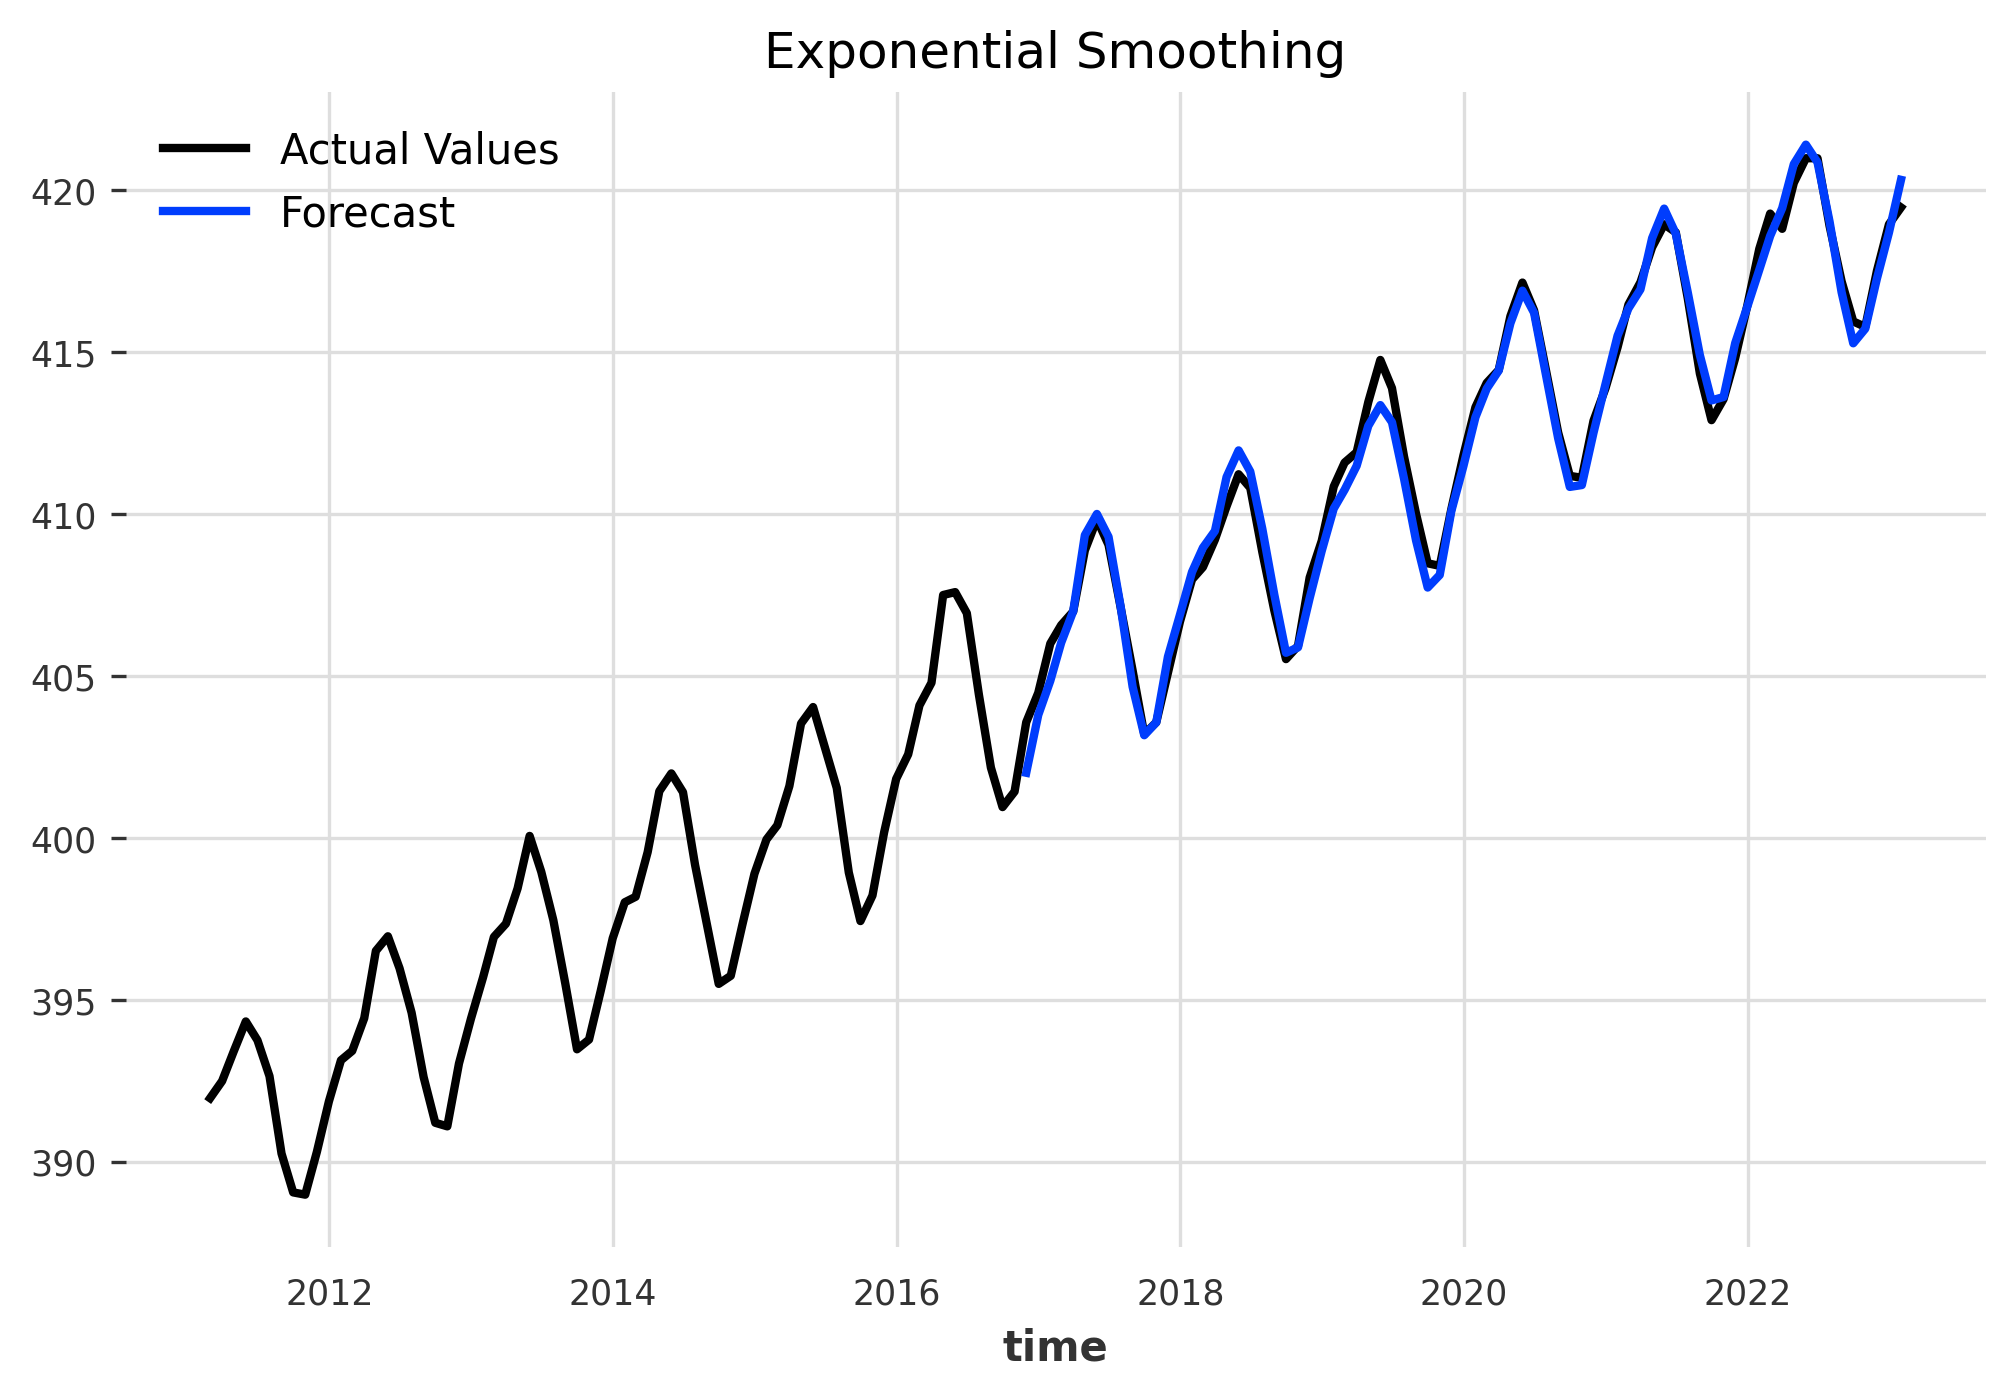

In [ ]:
# Docs de referencia:
# - Darts ExponentialSmoothing: 
#   https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html
# - Statsmodels Holt-Winters:
#   https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

model = ExponentialSmoothing(seasonal_periods=12)  
# Crea un modelo de Suavizado Exponencial con estacionalidad.
# - seasonal_periods=12 → la estacionalidad se repite cada 12 pasos (ej. 12 meses en datos mensuales).
# El modelo pondera más los datos recientes que los antiguos (decay exponencial).

model_name = 'Exponential Smoothing'  
# Nombre para el gráfico y reporte.

plt.figure(figsize=(8, 5))  
# Define el tamaño del gráfico.

forecast = model.historical_forecasts(
    series, 
    start=start, 
    forecast_horizon=12, 
    verbose=True
)  
# Calcula pronósticos retrospectivos ("backtesting") para evaluar el modelo:
# - series: la serie temporal original.
# - start: punto inicial desde donde se comienzan los pronósticos.
# - forecast_horizon=12: predice 12 pasos hacia adelante cada vez.
# - verbose=True: muestra mensajes de progreso.

plot_backtest(series, forecast, model_name)  
# Grafica los valores reales de la serie junto con los pronósticos generados.


In [ ]:
df_exp = print_metrics(series, forecast, model_name)   # calcula métricas del modelo actual (Exponential Smoothing, por ej.) y las guarda en df_exp

df_metrics = pd.concat([df_metrics, df_exp])           # agrega esas métricas al DataFrame acumulador df_metrics

df_exp                                                 # muestra en pantalla solo las métricas recién calculadas


,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing,0.42,0.53,0.1,0.1,0.99


In [ ]:
df_metrics

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.39,2.45,0.58,0.58,0.73
Exponential Smoothing,0.42,0.53,0.10,0.10,0.99


# Creating a Linear Regression Forecasting Model

100%|██████████| 75/75 [00:01<00:00, 62.77it/s]


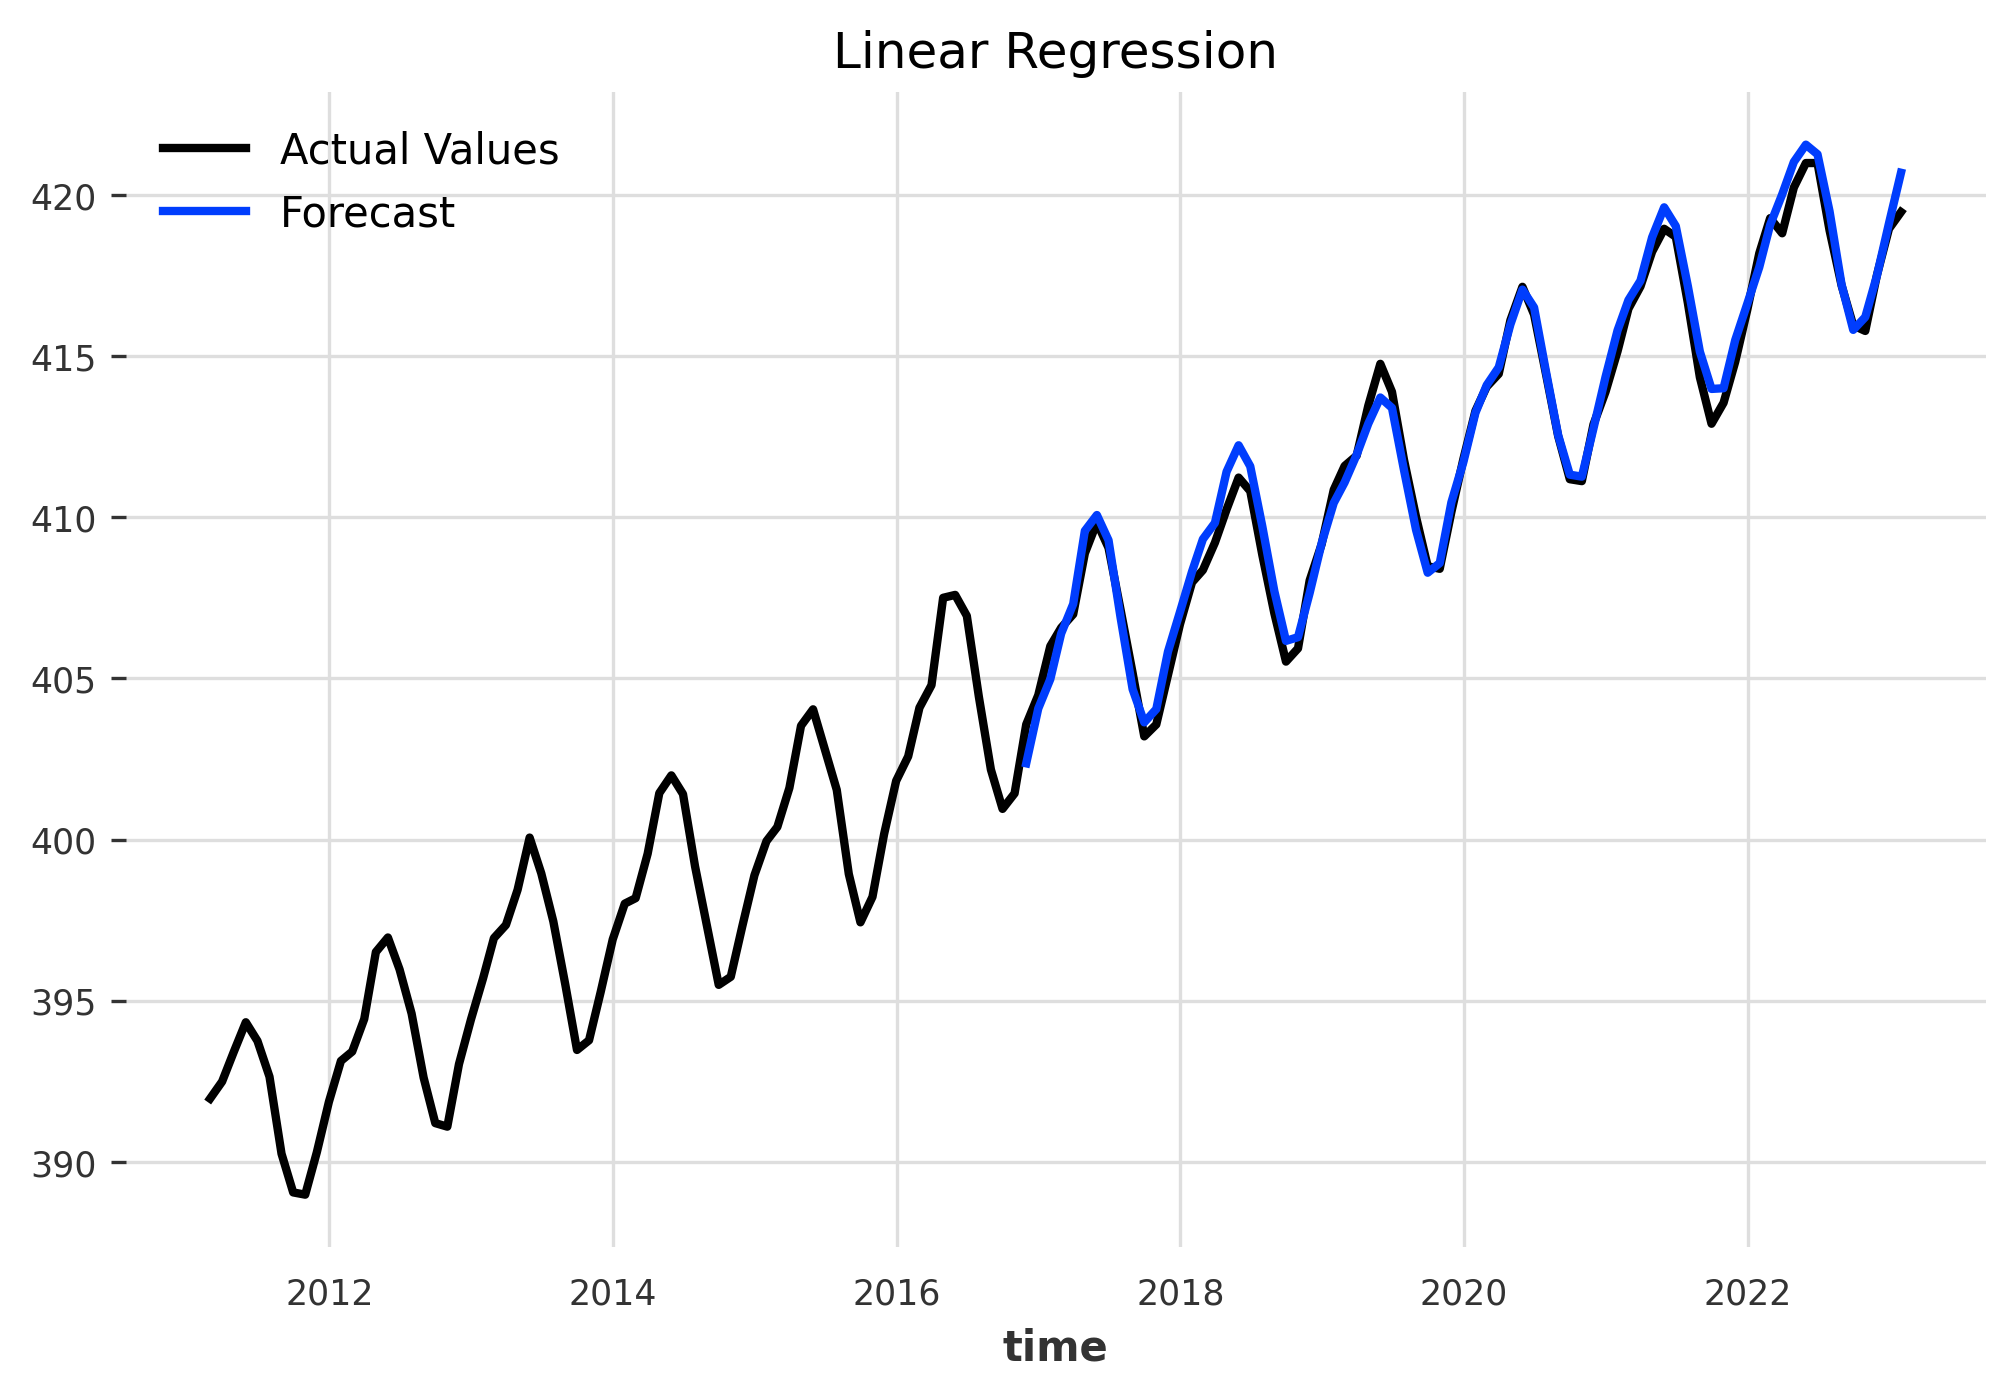

In [ ]:
# Doc oficial:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html

model = LinearRegressionModel(lags=12)  
# Crea un modelo de regresión lineal para series temporales.
# - lags=12 → usa los últimos 12 valores de la serie como variables predictoras (features).
#   Ejemplo: para predecir el mes t, usa los datos de los 12 meses anteriores.

model_name = 'Linear Regression'  
# Nombre del modelo para mostrar en los gráficos y resultados.

plt.figure(figsize=(8, 5))  
# Define el tamaño del gráfico.

forecast = model.historical_forecasts(
    series,
    start=start,
    forecast_horizon=12,
    verbose=True
)  
# Hace "backtesting" con el modelo de regresión lineal:
# - series: la serie temporal original.
# - start: punto a partir del cual empiezan los pronósticos.
# - forecast_horizon=12: predice 12 pasos hacia adelante en cada iteración.
# - verbose=True: muestra el progreso en consola.

plot_backtest(series, forecast, model_name)  
# Usa tu función personalizada para graficar los valores reales vs. los pronosticados.

plt.show()  
# Muestra el gráfico final en pantalla.


In [ ]:
df_lr = print_metrics(series, forecast, model_name)   # calcula métricas (MAE, RMSE, MAPE, SMAPE, R2) del modelo de regresión lineal y las guarda en df_lr
df_lr                                                # muestra en pantalla las métricas de este modelo

,MAE,RMSE,MAPE,SMAPE,R2
Linear Regression,0.45,0.55,0.11,0.11,0.99


In [ ]:
df_metrics = pd.concat([df_metrics, df_lr])   # agrega las métricas del modelo de regresión lineal al DataFrame acumulador df_metrics
df_metrics                                   # muestra toda la tabla con las métricas de todos los modelos evaluados

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.39,2.45,0.58,0.58,0.73
Exponential Smoothing,0.42,0.53,0.10,0.10,0.99
Exponential Smoothing,0.42,0.53,0.10,0.10,0.99
Linear Regression,0.45,0.55,0.11,0.11,0.99


# Creating a DL Forecasting Model

In [ ]:
# Docs:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html
# https://towardsdatascience.com/temporal-convolutional-networks-the-next-revolution-for-time-series-8990af826567

model = TCNModel(
    input_chunk_length=24,   # Ventana de entrada: usa 24 pasos anteriores como input
    output_chunk_length=12,  # Ventana de salida: predice 12 pasos hacia adelante
    n_epochs=100,            # Número de épocas de entrenamiento
    dropout=0.1,             # Dropout para evitar overfitting
    dilation_base=3,         # Factor de dilatación para convoluciones (captura dependencias largas)
    weight_norm=True,        # Normalización de pesos → estabiliza el entrenamiento
    kernel_size=5,           # Tamaño del kernel de las convoluciones
    num_filters=3,           # Número de filtros convolucionales por capa
    random_state=0,          # Semilla para reproducibilidad
)

model_name = 'TCN'  
# Nombre del modelo para mostrar en gráficos y métricas.

plt.figure(figsize=(8, 5))  
# Define el tamaño del gráfico.

scaler = Scaler()  
scaled_series = scaler.fit_transform(series)  
# Normaliza la serie (muy importante para redes neuronales).
# Escalar evita que valores grandes dominen el entrenamiento.

forecast = model.historical_forecasts(
    scaled_series,
    start=start,
    forecast_horizon=12,
    verbose=True
)  
# Hace backtesting con el TCN:
# - Usa la serie escalada.
# - forecast_horizon=12 → predice 12 pasos hacia adelante.
# - verbose=True → muestra el progreso.

plot_backtest(series, scaler.inverse_transform(forecast), model_name)  
# Grafica los valores reales vs. los pronósticos.
# Los pronósticos se transforman de nuevo a la escala original (inverse_transform).



  0%|          | 0/75 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  1%|▏         | 1/75 [00:52<1:04:48, 52.55s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  3%|▎         | 2/75 [01:39<1:00:09, 49.45s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  4%|▍         | 3/75 [02:27<58:14, 48.53s/it]  

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  5%|▌         | 4/75 [03:16<57:52, 48.91s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  7%|▋         | 5/75 [04:07<57:40, 49.43s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  8%|▊         | 6/75 [04:56<56:38, 49.25s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  9%|▉         | 7/75 [06:09<1:04:48, 57.18s/it]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


 11%|█         | 8/75 [06:57<1:00:34, 54.25s/it]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_dl = print_metrics(series, scaler.inverse_transform(forecast), model_name)  
# calcula métricas del modelo deep learning (ej. TCN),
# usando la serie real vs. el forecast reescalado a valores originales
# guarda el resultado en df_dl

df_dl  
# muestra en pantalla la fila de métricas recién calculadas


In [ ]:
df_metrics = pd.concat([df_metrics, df_dl])   # agrega las métricas de df_dl al acumulador df_metrics
df_metrics                                   # muestra la tabla completa con todas las métricas

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.39,2.45,0.58,0.58,0.73
Exponential Smoothing,0.42,0.53,0.10,0.10,0.99
Linear Regression,0.45,0.55,0.11,0.11,0.99
TCN,1.13,1.34,0.27,0.27,0.92


# Creating a Forecast

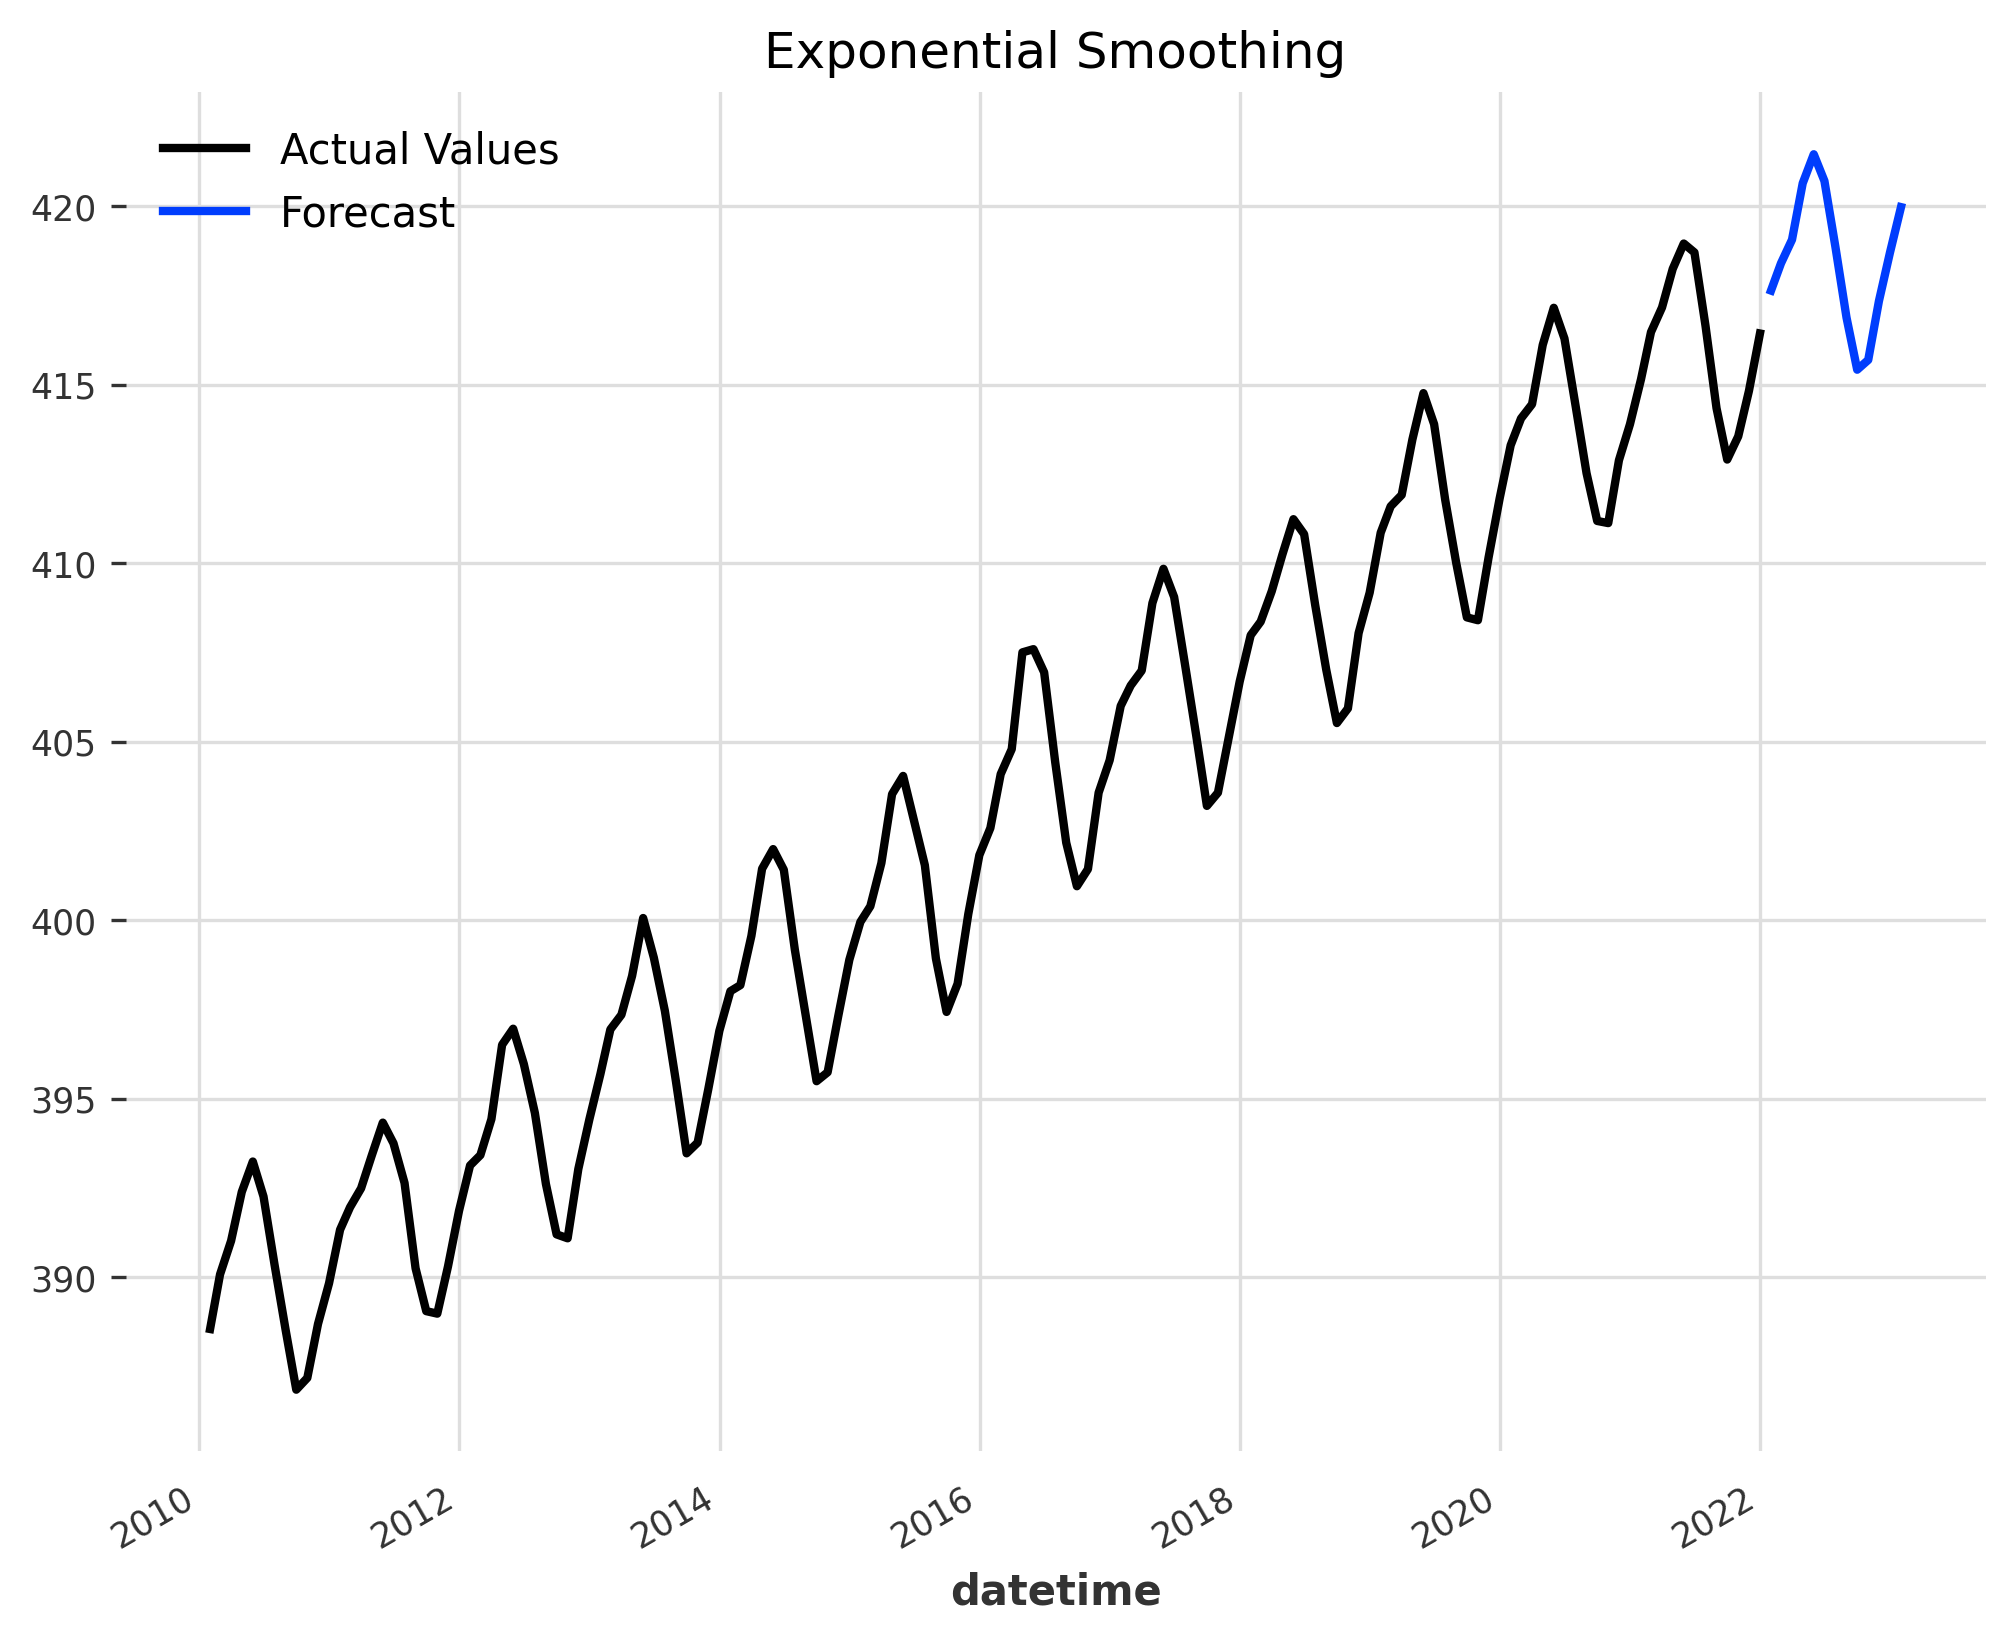

component          CO2
datetime              
2022-01-31  417.632844
2022-02-28  418.396291
2022-03-31  419.057940
2022-04-30  420.637396
2022-05-31  421.450293
2022-06-30  420.702143
2022-07-31  418.846183
2022-08-31  416.877524
2022-09-30  415.416149
2022-10-31  415.689637
2022-11-30  417.336943
2022-12-31  418.695029
2023-01-31  419.969626
component      CO2
datetime          
2022-01-31  418.19
2022-02-28  419.28
2022-03-31  418.81
2022-04-30  420.23
2022-05-31  420.99
2022-06-30  420.99
2022-07-31  418.90
2022-08-31  417.19
2022-09-30  415.95
2022-10-31  415.78
2022-11-30  417.51
2022-12-31  418.95
2023-01-31  419.47


In [ ]:
model = ExponentialSmoothing(seasonal_periods=12)  
# Crea un modelo Holt-Winters de Suavizado Exponencial con estacionalidad.
# seasonal_periods=12 → estacionalidad anual (si los datos son mensuales).

model_name = 'Exponential Smoothing'  
# Nombre del modelo para usar en gráficos y resultados.

series1, series2 = series[:-13], series[-13:]  
# Divide la serie en entrenamiento y test:
# - series1: todos los datos excepto los últimos 13 → entrenamiento.
# - series2: los últimos 13 → test (validación).

model.fit(series1)  
# Ajusta (entrena) el modelo con los datos de entrenamiento.

forecast = model.predict(13)  
# Genera un pronóstico de 13 pasos hacia adelante (mismo horizonte que series2).

plot_backtest(series1, forecast, model_name)  
# Grafica:
# - Serie real de entrenamiento (series1).
# - Pronóstico generado (forecast).

print(forecast.pd_dataframe())  
# Convierte el pronóstico en un DataFrame de pandas y lo imprime.
# Muestra las fechas pronosticadas y sus valores estimados.

print(series2.pd_dataframe())  
# Convierte la serie de validación (los últimos 13 puntos reales) en DataFrame.
# Permite comparar valores reales vs. pronóstico.
